In [2]:
import numpy as np
import pandas as pd

import os

print(os.listdir(r'C:\Users\CANARA BANK\Desktop\input'))

['test_data', 'test_images', 'test_lidar', 'test_maps', 'train_data (1)', 'train_images', 'train_lidar', 'train_maps']


In [3]:
import json
import os
import os.path
import numpy as np
import pandas as pd
import random
import itertools
import copy
import math
from matplotlib import pyplot as plt
import pyquaternion
from pyquaternion import Quaternion
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from skimage.morphology import convex_hull_image

import tensorflow as tf

import keras
from keras import backend as K
from keras.engine import Input, Model
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization, PReLU, Deconvolution3D
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.losses import binary_crossentropy

K.set_image_data_format("channels_first")

try:
    from keras.engine import merge
except ImportError:
    from keras.layers.merge import concatenate
    

In C:\Users\CANARA BANK\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\CANARA BANK\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\CANARA BANK\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\CANARA BANK\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\CANARA BANK\Miniconda3\lib\site-packages\matplotlib\

In [5]:
#Load json files from dataset
class Table:
    def __init__(self, data):
        self.data = data
        self.index = {x['token']: x for x in data}


DATA_ROOT = r'C:\Users\CANARA BANK\Desktop\input'


def load_table(name, root=os.path.join(DATA_ROOT, 'train_data')):
    with open(os.path.join(root, name), 'rb') as f:
        return Table(json.load(f))

    
scene = load_table('scene.json')
sample = load_table('sample.json')
sample_data = load_table('sample_data.json')
ego_pose = load_table('ego_pose.json')
calibrated_sensor = load_table('calibrated_sensor.json')

In [25]:
# let's check the first scene
my_scene = scene.data[0]
my_scene

{'log_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100',
 'first_sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'name': 'host-a101-lidar0-1241893239199111666-1241893264098084346',
 'description': '',
 'last_sample_token': '2346756c83f6ae8c4d1adec62b4d0d31b62116d2e1819e96e9512667d15e7cec',
 'nbr_samples': 126,
 'token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'}

In [26]:
#And the first sample from that scene
sample.index[my_scene['first_sample_token']]


{'next': 'c2ba18e4414ce9038ad52efab44e1a0a211ff1e6b297a632805000510756174d',
 'prev': '',
 'token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'timestamp': 1557858039302414.8,
 'scene_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'}

In [27]:
#We'll use sample_data to fetch lidar images related to this sample. First check what is inside sample_data
sample_data.data[0]


{'is_key_frame': True,
 'prev': 'd190078ec7869ad5c9e5417371aa3b45eb1c22804a0a290ed4695042799b7470',
 'fileformat': 'bin',
 'token': 'ad87e1763749cc8562cca68e2046db128185c80c3e759919f5da448e5d9d9696',
 'timestamp': 1549920983701948.2,
 'next': '8182fb6868baf63c245a4994b7f3034a7d281d1928a7844b7b7159cff3b91a1e',
 'ego_pose_token': 'd90d278f2084ae64c98b0aa2dd8d4f83c023f1313beeaebdcefbf4529209237f',
 'sample_token': 'fd5f1c634b59e3b4e0f7a5c48c768a7d334a63221fced363a2ebac41f465830d',
 'filename': 'lidar/host-a007_lidar1_1233956183701948366.bin',
 'calibrated_sensor_token': '3b463530b5bae9698c9cc803c1731c36abd359a7296e23e81f8c0b546f60e749'}

In [28]:
#Now fetch lidar images related to the sample (note that to make it efficient you'll want to add an index like in official SDK)
lidars = []
for x in sample_data.data:
    if x['sample_token'] == my_scene['first_sample_token'] and 'lidar' in x['filename']:
        lidars.append(x)
lidars

[{'is_key_frame': True,
  'prev': '',
  'fileformat': 'bin',
  'token': '8cfae06bc3d5d7f9be081f66157909ff18c9f332cc173d962460239990c7a4ff',
  'timestamp': 1557858039302414.8,
  'next': 'c9dfdcd012a4946eae21a83e52e45de09ca930621e7ca7c5b78503a73509fb31',
  'ego_pose_token': '2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde',
  'sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
  'calibrated_sensor_token': 'dd9aad0c2aa0c75b9b0e227b568f64aac54f72c67956e759d6c629778c7734ef',
  'filename': 'lidar/host-a101_lidar2_1241893239302414726.bin'},
 {'is_key_frame': True,
  'prev': '',
  'fileformat': 'bin',
  'token': 'ec9950f7b5d4ae85ae48d07786e09cebbf4ee771d054353f1e24a95700b4c4af',
  'timestamp': 1557858039302414.8,
  'next': 'b2fb6b275352ff1bc8d63cae2ec88561dddb044cae6f8e6ee7ada4ed07d79dc7',
  'ego_pose_token': '2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde',
  'sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db2

In [29]:
#All lidars happen to have the same ego_pose (because they are on the same car?)
{x['ego_pose_token'] for x in lidars}

{'2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde'}

In [41]:
#Now let's load lidar's point data, we'll keep only first 3 columns (point coordinates)
lidars_data = [
    # here, sorry
    np.fromfile(os.path.join(DATA_ROOT, str(x['filename']).replace('lidar', 'train_lidar')), dtype=np.float32)
    .reshape(-1, 5)[:, :3] for x in lidars]
lidars_data[0].shape

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\CANARA BANK\\Desktop\\input\\train_lidar/host-a101_train_lidar2_1241893239302414726.bin'

In [11]:
train_df = pd.read_csv(os.path.join(DATA_ROOT, 'train.csv')).set_index('Id')

In [8]:
#Helpers to rotate bounding box points
def rotate_points(points, rotation, inverse=False):
    assert points.shape[1] == 3
    q = Quaternion(rotation)
    if inverse:
        q = q.inverse
    return np.dot(q.rotation_matrix, points.T).T
    
def apply_pose(points, cs, inverse=False):
    """ Translate (lidar) points to vehicle coordinates, given a calibrated sensor.
    """
    points = rotate_points(points, cs['rotation'])
    points = points + np.array(cs['translation'])
    return points

def inverse_apply_pose(points, cs):
    """ Reverse of apply_pose (we'll need it later).
    """
    points = points - np.array(cs['translation']) 
    points = rotate_points(points, np.array(cs['rotation']), inverse=True)
    return points

def get_annotations(token):
    annotations = np.array(train_df.loc[token].PredictionString.split()).reshape(-1, 8)
    return {
        'point': annotations[:, :3].astype(np.float32),
        'wlh': annotations[:, 3:6].astype(np.float32),
        'rotation': annotations[:, 6].astype(np.float32),
        'cls': np.array(annotations[:, 7]),
    }

In [15]:
#Helpers to rotate bounding box points
import copy

import math

def rotate(origin, point, angle):
    ox, oy, _ = origin
    px, py, pz = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return [qx, qy, pz]


def make_box_coords(center, wlh, rotation, ep):

    planar_wlh = copy.deepcopy(wlh)
    planar_wlh = planar_wlh[[1,0,2]]

    bottom_center = copy.deepcopy(center)
    bottom_center[-1] = bottom_center[-1] - planar_wlh[-1] / 2

    bottom_points = []
    bottom_points.append(bottom_center + planar_wlh * [1, 1, 0] / 2)
    bottom_points.append(bottom_center + planar_wlh * [-1, -1, 0] / 2)
    bottom_points.append(bottom_center + planar_wlh * [1, -1, 0] / 2)
    bottom_points.append(bottom_center + planar_wlh * [-1, 1, 0] / 2)
    bottom_points = np.array(bottom_points)

    rotated_bottom_points = []
    for point in bottom_points:
        rotated_bottom_points.append(rotate(bottom_center, point, rotation))

    rotated_bottom_points = np.array(rotated_bottom_points)
    rotated_top_points = rotated_bottom_points + planar_wlh * [0,0,1]

    box_points = np.concatenate([rotated_bottom_points, rotated_top_points], axis=0)

    box_points = inverse_apply_pose(box_points, ep)
    
    return box_points

In [16]:
#Helpers to get training data in raster format. To each sample we can create raster 1000x1000x100 image as 3-dimensional histogram of points. Mask is bounding boxes of cars. There is get_crop_positive function to create small crops from sample image to put it in neural network
def get_sample_data(sample_token):
    lidars = []
    for x in sample_data.data:
        if x['sample_token'] == sample_token and 'lidar' in x['filename']:
            lidars.append(x)

    lidars_data = [
        # here, sorry
        np.fromfile(os.path.join(DATA_ROOT, x['filename'].replace('lidar/', 'train_lidar/')), dtype=np.float32)
        .reshape(-1, 5)[:, :3] for x in lidars]


    all_points = []
    all_colors = []
    for points, lidar in zip(lidars_data, lidars):
        cs = calibrated_sensor.index[lidar['calibrated_sensor_token']]
        points = apply_pose(points, cs)
        all_points.append(points)
    all_points = np.concatenate(all_points)


    ego_pose_token, = {x['ego_pose_token'] for x in lidars}
    ep = ego_pose.index[ego_pose_token]
    annotations = get_annotations(sample_token)

    car_centers = annotations['point'][annotations['cls'] == 'car']
    car_wlhs = annotations['wlh'][annotations['cls'] == 'car']
    car_rotations = annotations['rotation'][annotations['cls'] == 'car']

    truck_centers = annotations['point'][annotations['cls'] == 'truck']
    truck_wlhs = annotations['wlh'][annotations['cls'] == 'truck']
    truck_rotations = annotations['rotation'][annotations['cls'] == 'truck']

    other_vehicle_centers = annotations['point'][annotations['cls'] == 'other_vehicle']
    other_vehicle_wlhs = annotations['wlh'][annotations['cls'] == 'other_vehicle']
    other_vehicle_rotations = annotations['rotation'][annotations['cls'] == 'other_vehicle']
    
    bus_centers = annotations['point'][annotations['cls'] == 'bus']
    bus_wlhs = annotations['wlh'][annotations['cls'] == 'bus']
    bus_rotations = annotations['rotation'][annotations['cls'] == 'bus']

    pedestrian_centers = annotations['point'][annotations['cls'] == 'pedestrian']
    pedestrian_wlhs = annotations['wlh'][annotations['cls'] == 'pedestrian']
    pedestrian_rotations = annotations['rotation'][annotations['cls'] == 'pedestrian']

    bicycle_centers = annotations['point'][annotations['cls'] == 'bicycle']
    bicycle_wlhs = annotations['wlh'][annotations['cls'] == 'bicycle']
    bicycle_rotations = annotations['rotation'][annotations['cls'] == 'bicycle']


    # Car
    car_boxes = []
    for k in range(len(car_centers)):
        center = car_centers[k]
        wlh = car_wlhs[k]
        rotation = car_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        car_boxes.append(box_coords)

    car_boxes = np.array(car_boxes)    
    car_centers = inverse_apply_pose(car_centers, ep)
    
    # Truck
    truck_boxes = []
    for k in range(len(truck_centers)):
        center = truck_centers[k]
        wlh = truck_wlhs[k]
        rotation = truck_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        truck_boxes.append(box_coords)

    truck_boxes = np.array(truck_boxes)    
    truck_centers = inverse_apply_pose(truck_centers, ep)
    
    # Other vehicle
    other_vehicle_boxes = []
    for k in range(len(other_vehicle_centers)):
        center = other_vehicle_centers[k]
        wlh = other_vehicle_wlhs[k]
        rotation = other_vehicle_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        other_vehicle_boxes.append(box_coords)

    other_vehicle_boxes = np.array(other_vehicle_boxes)    
    other_vehicle_centers = inverse_apply_pose(other_vehicle_centers, ep)
    
    # Bus
    bus_boxes = []
    for k in range(len(bus_centers)):
        center = bus_centers[k]
        wlh = bus_wlhs[k]
        rotation = bus_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        bus_boxes.append(box_coords)

    bus_boxes = np.array(bus_boxes)    
    bus_centers = inverse_apply_pose(bus_centers, ep)
    
    # Pedestrian
    pedestrian_boxes = []
    for k in range(len(pedestrian_centers)):
        center = pedestrian_centers[k]
        wlh = pedestrian_wlhs[k]
        rotation = pedestrian_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        pedestrian_boxes.append(box_coords)

    pedestrian_boxes = np.array(pedestrian_boxes)    
    pedestrian_centers = inverse_apply_pose(pedestrian_centers, ep)
    
    # Bicycle
    bicycle_boxes = []
    for k in range(len(bicycle_centers)):
        center = bicycle_centers[k]
        wlh = bicycle_wlhs[k]
        rotation = bicycle_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        bicycle_boxes.append(box_coords)

    bicycle_boxes = np.array(bicycle_boxes)    
    bicycle_centers = inverse_apply_pose(bicycle_centers, ep)
    
    return all_points, \
        car_boxes, car_centers, \
        truck_boxes, truck_centers, \
        other_vehicle_boxes, other_vehicle_centers, \
        bus_boxes, bus_centers, \
        pedestrian_boxes, pedestrian_centers, \
        bicycle_boxes, bicycle_centers


def get_sample_raster(all_points, all_boxes): 
    x_bounds = np.linspace(-100, 100, 1001)
    y_bounds = np.linspace(-100, 100, 1001)
    z_bounds = np.linspace(-10, 10, 101)

    sample_hist = np.histogramdd(all_points[:], [x_bounds, y_bounds, z_bounds])[0]
    sample_mask = np.zeros((len(x_bounds)-1, len(y_bounds)-1, len(z_bounds)-1))



    for box in all_boxes:
        x_min, y_min, z_min = box.min(axis=0)
        x_max, y_max, z_max = box.max(axis=0)

        x_box_bound_cnt = int(1001 / 200 * (x_max - x_min))
        y_box_bound_cnt = int(1001 / 200 * (y_max - y_min))
        z_box_bound_cnt = int(101 / 20 * (z_max - z_min))

        box_hist = np.histogramdd(box, [np.linspace(x_min, x_max, x_box_bound_cnt),
                                        np.linspace(y_min, y_max, y_box_bound_cnt),
                                        np.linspace(z_min, z_max, z_box_bound_cnt)])[0]


        try:
            box_mask = convex_hull_image(box_hist)
        except:
            continue


        x_start_idx = np.where(x_bounds > x_min)[0][0]
        y_start_idx = np.where(y_bounds > y_min)[0][0]
        z_start_idx = np.where(z_bounds > z_min)[0][0]


        x_cnt = min(sample_mask.shape[0] - x_start_idx - 1, x_box_bound_cnt - 1)
        y_cnt = min(sample_mask.shape[1] - y_start_idx - 1, y_box_bound_cnt - 1)
        z_cnt = min(sample_mask.shape[2] - z_start_idx - 1, z_box_bound_cnt - 1)

        sample_mask[x_start_idx:x_start_idx+x_cnt,
                   y_start_idx:y_start_idx+y_cnt,
                   z_start_idx:z_start_idx+z_cnt] = sample_mask[x_start_idx:x_start_idx+x_cnt,
                                                                           y_start_idx:y_start_idx+y_cnt,
                                                                           z_start_idx:z_start_idx+z_cnt] + box_mask[:x_cnt, :y_cnt, :z_cnt]

    return sample_hist, sample_mask, (x_bounds, y_bounds, z_bounds)


def get_crop_positive(sample_hist, sample_mask, bounds, centers, crop_size=(64, 64, 32)):
    
    half_x_size = crop_size[0] // 2
    half_y_size = crop_size[1] // 2
    half_z_size = crop_size[2] // 2
    
    (x_bounds, y_bounds, z_bounds) = bounds
    if len(centers) > 0:
        idx = np.random.choice(range(len(centers)))
        x_center, y_center, z_center = centers[idx]
    else:
        x_center, y_center = np.random.randint(-30, 30, 2)
        z_center = np.random.randint(-10, 10)

    x_center, y_center, z_center = [x_center, y_center, z_center] + np.random.randint(-3, 3, 3)

    x_center = min(x_center, 100 - np.abs(x_bounds[-1] - x_bounds[-2]) * half_x_size - 1)
    x_center = max(x_center, -100 + np.abs(x_bounds[-1] - x_bounds[-2]) * half_x_size + 1)

    y_center = min(y_center, 100 - np.abs(y_bounds[-1] - y_bounds[-2]) * half_y_size - 1)
    y_center = max(y_center, -100 + np.abs(y_bounds[-1] - y_bounds[-2]) * half_y_size + 1)

    z_center = min(z_center, 10 - np.abs(z_bounds[-1] - z_bounds[-2]) * half_z_size - 1)
    z_center = max(z_center, -10 + np.abs(z_bounds[-1] - z_bounds[-2]) * half_z_size + 1)




    x_center_idx = np.where(x_bounds > x_center)[0][0]
    y_center_idx = np.where(y_bounds > y_center)[0][0]
    z_center_idx = np.where(z_bounds > z_center)[0][0]

        
    crop_hist = sample_hist[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    
    crop_mask = sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]

    return crop_hist, crop_mask > 0



def get_crop_over_all_classes(sample_hist, bounds, \
                              car_sample_mask, truck_sample_mask, \
                              other_vehicle_sample_mask, bus_sample_mask, \
                              pedestrian_sample_mask, bicycle_sample_mask, \
                              car_centers, truck_centers, \
                              other_vehicle_centers, bus_centers, \
                              pedestrian_centers, bicycle_centers, \
                              crop_size=(64, 64, 32)):
    
    half_x_size = crop_size[0] // 2
    half_y_size = crop_size[1] // 2
    half_z_size = crop_size[2] // 2
    
    (x_bounds, y_bounds, z_bounds) = bounds
    
    centers = np.concatenate((car_centers, truck_centers, other_vehicle_centers, bus_centers, pedestrian_centers, bicycle_centers), axis=0)
    if len(centers) > 0:
        idx = np.random.choice(range(len(centers)))
        x_center, y_center, z_center = centers[idx]
    else:
        x_center, y_center = np.random.randint(-30, 30, 2)
        z_center = np.random.randint(-10, 10)


    x_center, y_center, z_center = [x_center, y_center, z_center] + np.random.randint(-3, 3, 3)

    x_center = min(x_center, 100 - np.abs(x_bounds[-1] - x_bounds[-2]) * half_x_size - 1)
    x_center = max(x_center, -100 + np.abs(x_bounds[-1] - x_bounds[-2]) * half_x_size + 1)

    y_center = min(y_center, 100 - np.abs(y_bounds[-1] - y_bounds[-2]) * half_y_size - 1)
    y_center = max(y_center, -100 + np.abs(y_bounds[-1] - y_bounds[-2]) * half_y_size + 1)

    z_center = min(z_center, 10 - np.abs(z_bounds[-1] - z_bounds[-2]) * half_z_size - 1)
    z_center = max(z_center, -10 + np.abs(z_bounds[-1] - z_bounds[-2]) * half_z_size + 1)




    x_center_idx = np.where(x_bounds > x_center)[0][0]
    y_center_idx = np.where(y_bounds > y_center)[0][0]
    z_center_idx = np.where(z_bounds > z_center)[0][0]

        
    crop_hist = sample_hist[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    
    car_crop_mask = car_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    truck_crop_mask = truck_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    other_vehicle_crop_mask = other_vehicle_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    bus_crop_mask = bus_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    pedestrian_crop_mask = pedestrian_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    bicycle_crop_mask = bicycle_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]

    crop_mask = np.array((car_crop_mask, truck_crop_mask, other_vehicle_crop_mask, bus_crop_mask, pedestrian_crop_mask, bicycle_crop_mask))
    

    return crop_hist, crop_mask > 0

In [19]:
#Data example
sample_token = train_df.reset_index()['Id'].values[71]

all_points, car_boxes, car_centers, \
truck_boxes, truck_centers, \
other_vehicle_boxes, other_vehicle_centers, \
bus_boxes, bus_centers, \
pedestrian_boxes, pedestrian_centers, \
bicycle_boxes, bicycle_centers = get_sample_data(sample_token)

In [20]:
# sample_hist, sample_mask, bounds = get_sample_raster(all_points, all_boxes)

car_sample_hist, car_sample_mask, car_bounds = get_sample_raster(all_points, car_boxes)
truck_sample_hist, truck_sample_mask, truck_bounds = get_sample_raster(all_points, truck_boxes)
other_vehicle_sample_hist, other_vehicle_sample_mask, other_vehicle_bounds = get_sample_raster(all_points, other_vehicle_boxes)
bus_sample_hist, bus_sample_mask, bus_bounds = get_sample_raster(all_points, bus_boxes)
pedestrian_sample_hist, pedestrian_sample_mask, pedestrian_bounds = get_sample_raster(all_points, pedestrian_boxes)
bicycle_sample_hist, bicycle_sample_mask, bicycle_bounds = get_sample_raster(all_points, bicycle_boxes)

In [21]:
crop_hist, crop_mask = get_crop_over_all_classes(
    car_sample_hist, car_bounds, \
    car_sample_mask, truck_sample_mask, \
    other_vehicle_sample_mask, bus_sample_mask, \
    pedestrian_sample_mask, bicycle_sample_mask, \
    car_centers, truck_centers, \
    other_vehicle_centers, bus_centers, \
    pedestrian_centers, bicycle_centers, \
    crop_size=(128,128,64))

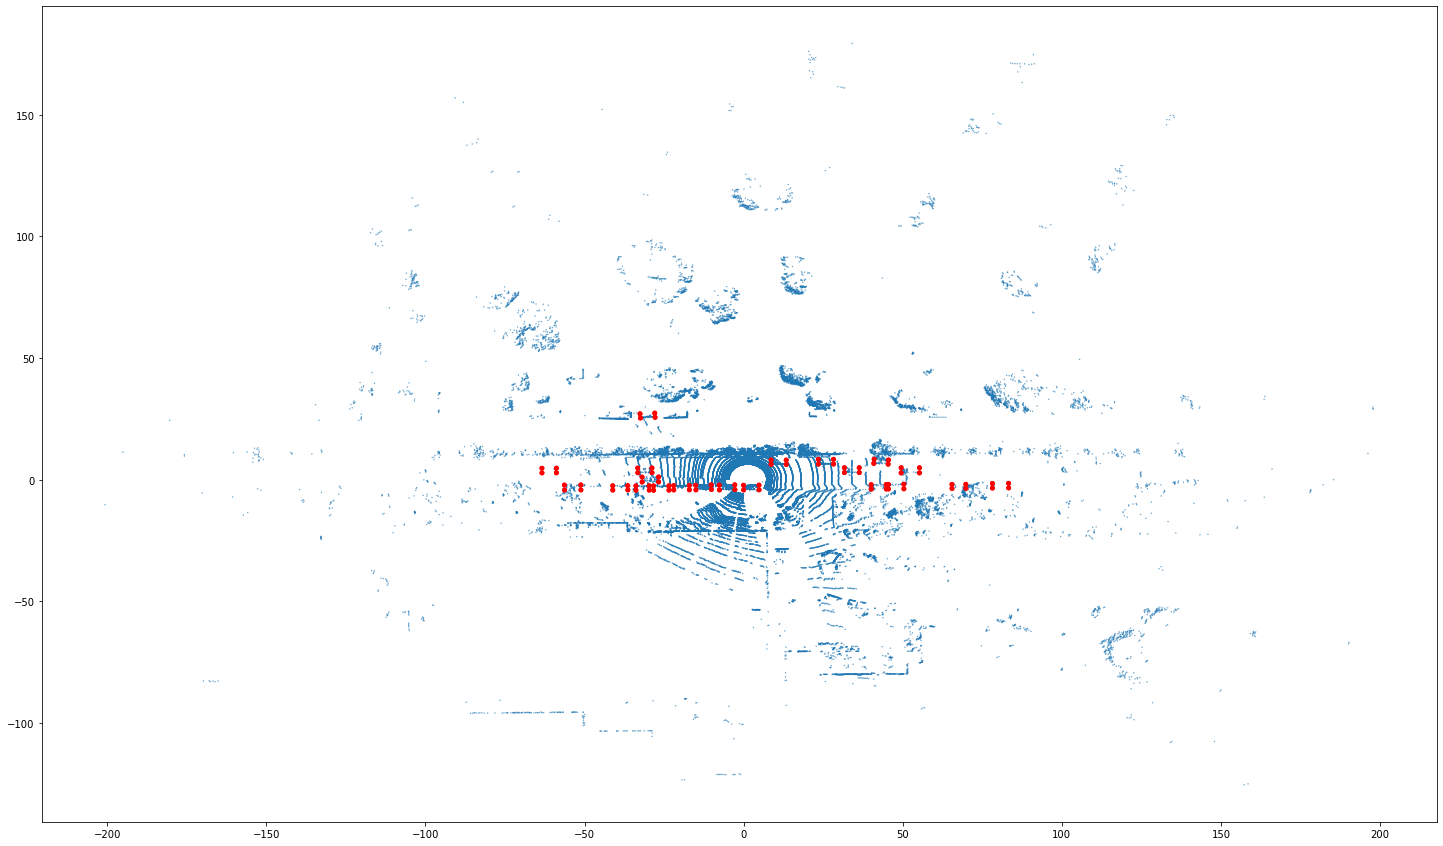

In [22]:
#Source point cloud for full sample
boxes_coords = np.concatenate(car_boxes, axis=0)


plt.figure(figsize=(25,15))
plt.scatter(all_points[:, 0], all_points[:, 1],s=[0.1]*len(all_points))
plt.scatter(boxes_coords[:, 0], boxes_coords[:, 1],s=[15]*len(boxes_coords),color='r')

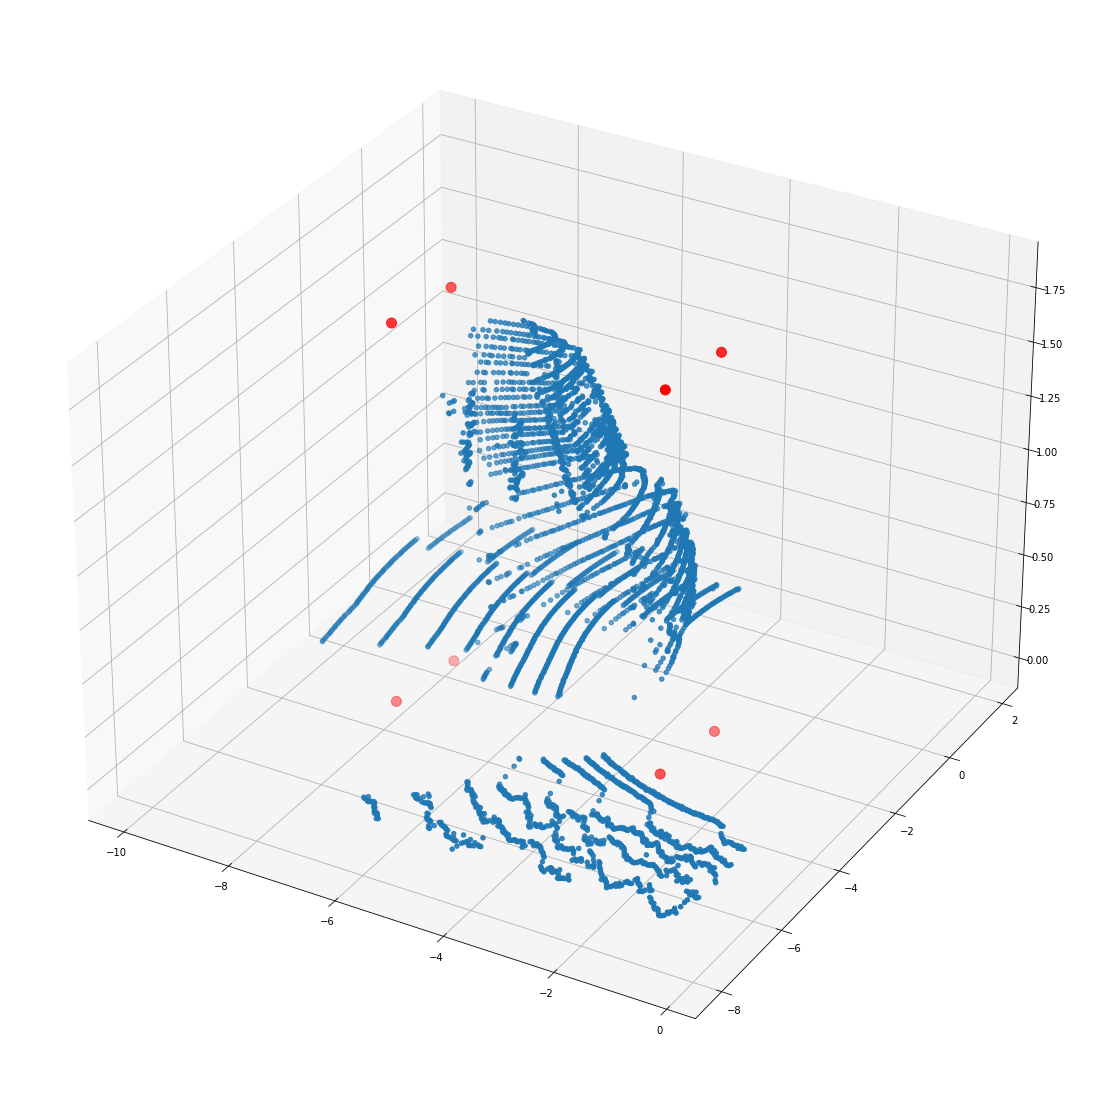

In [23]:
#Source point cloud for small region with car
ann_idx = 20

center_point = car_centers[ann_idx]
x_min = center_point[0] - 5
x_max = center_point[0] + 5
y_min = center_point[1] - 5
y_max = center_point[1] + 5
z_min= center_point[2] - 5
z_max = center_point[2] + 5


area_mask = (all_points[:, 0] > x_min) * (all_points[:, 0] < x_max) * (all_points[:, 1] > y_min) * (all_points[:, 1] < y_max) * (all_points[:, 2] > z_min) * (all_points[:, 2] < z_max)
area_mask = np.where(area_mask)[0]


fig = pyplot.figure(figsize=(25,15))
ax = Axes3D(fig)
ax.scatter(all_points[area_mask, 0], all_points[area_mask, 1], all_points[area_mask, 2])


ax.scatter(car_boxes[ann_idx][:, 0], car_boxes[ann_idx][:, 1], car_boxes[ann_idx][:, 2], color='r', s=[100])



pyplot.show()


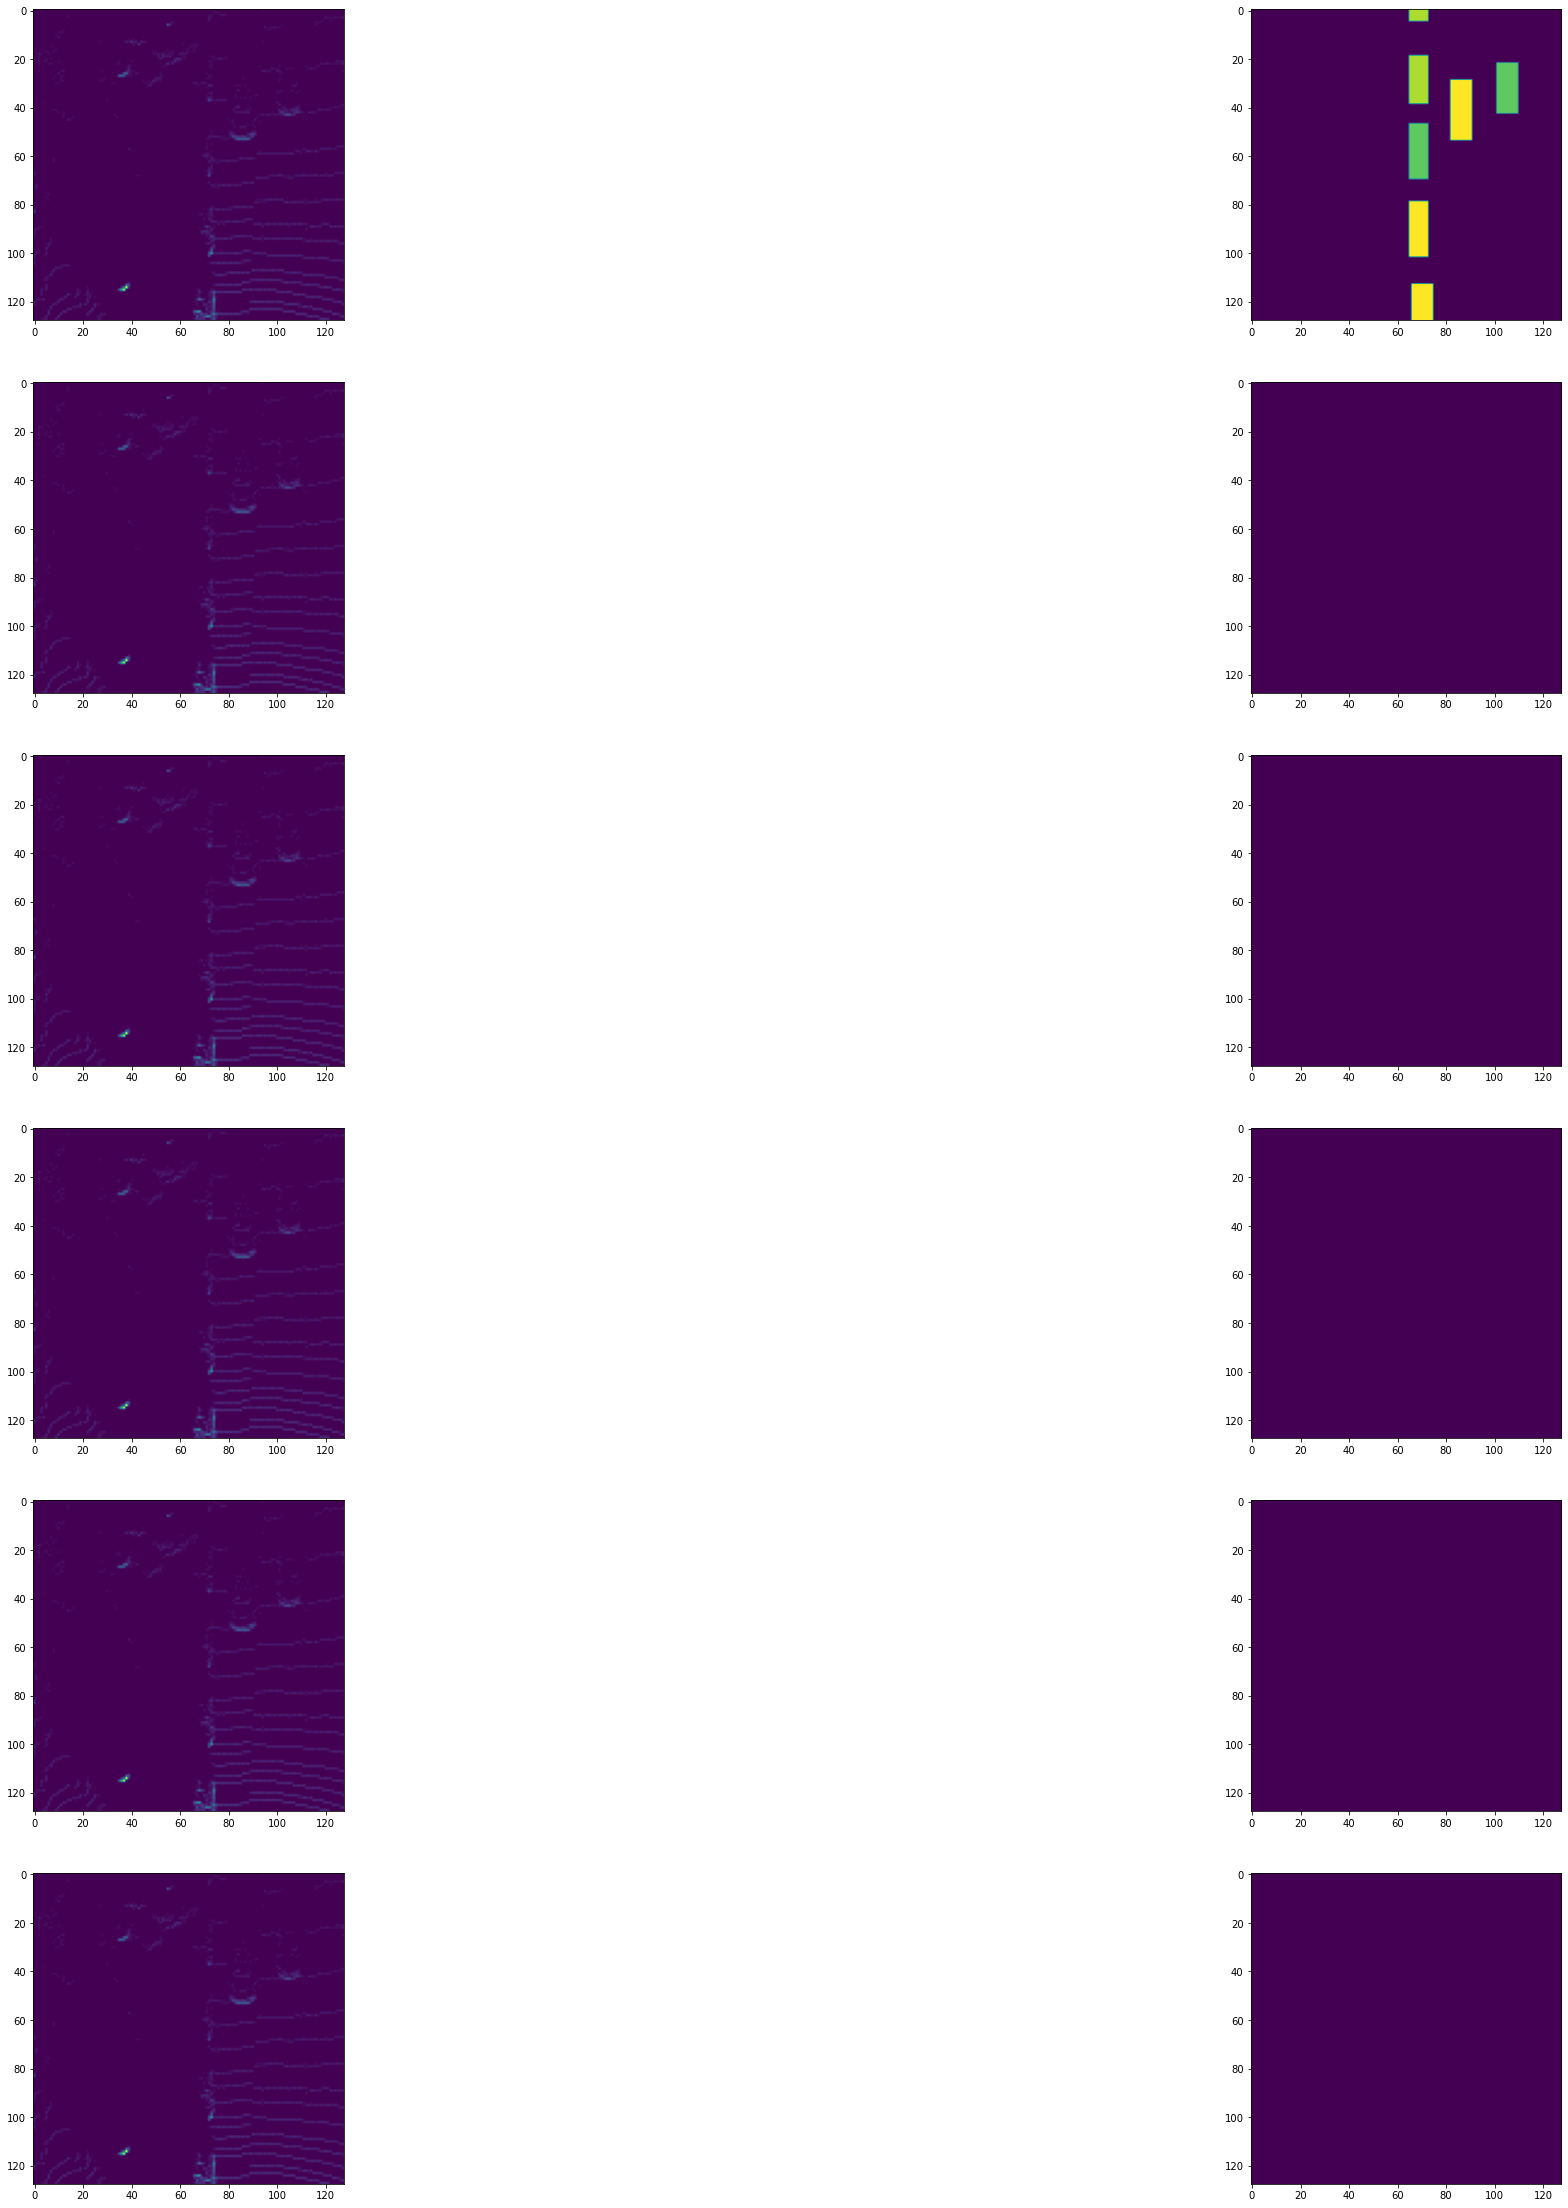

In [24]:
#Rastered crop of a small region
fig, axes = plt.subplots(6, 2, figsize=(40, 40))
for i in range(6):
    axes[i][0].imshow(crop_hist.sum(axis=-1))
    axes[i][1].imshow(crop_mask[i].sum(axis=-1))


plt.show()
